# Explore GNF normalization methods

## 0 Packages and presets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
import corrLib
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from scipy import signal
from scipy.interpolate import griddata
import matplotlib
import pandas as pd
from scipy.ndimage import gaussian_filter1d, uniform_filter1d
import typesetting.main as tm
from corr_utils import *
from IPython.display import clear_output
from log import experiment_log

In [19]:
color_dict, marker_list = unified_symbols() # keep color and symbol consistent across different plot, for same concentrations
data_master_dir = r'E:\Google Drive' # data folder: Google drive for now, but may change in the future
tm.prl('1-column-2-panel') # control the default plotting configurations, now I realize the parameters should vary from plot to plot
dirs = data_log_mapping(kw='aug') # video info for GNF raw data, obtained from Aug 3rd to Aug 6th
log_df = experiment_log()

-------The log looks OK!--------


## 1 Rescale the intensity to calibration curve

We have a calibration curve relating average intensity to local concentration. If we can rescale the average intensity of any image to the intensity where we measure the calibration curve, the image would (possibly) be as if it was taken under the illumination condition used during illumination. The assumption here is that:

**Multilying all pixel intensity by a constant is equivalent to tuning up and down illumination intensity**

Here, we first rescale the calibration intensity to 8-bit, since it was originally calculated in 11-bit. Then, we calculate and record the average intensity of all data. 

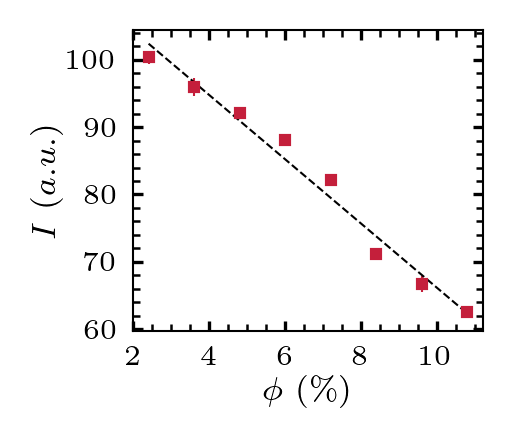

In [34]:
cali_data = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\n-I-calibration.csv'))
fig, ax = plt.subplots(figsize=(1.75, 1.50), dpi=300)
cali_data['I'] = cali_data['I'] / 2**11 * 2**8
cali_data['std'] = cali_data['std'] / 2**11 * 2**8
n0_vf = 0.12 # 1 n0 equivalent volume fraction
ax.errorbar(cali_data['n'] * n0_vf, cali_data['I'], yerr=cali_data['std'], ls='', 
            c=wowcolor(0), marker='s',  capsize=0, markersize=2, elinewidth=0.5)
p = np.polyfit(cali_data['n'] * n0_vf, cali_data['I'] , deg=1)
ax.plot(cali_data['n'] * n0_vf, p[0]*cali_data['n']*n0_vf+p[1], ls='--', color='black', lw=0.5)
ax.set_xlabel('$\phi$ (\%)')
ax.set_ylabel('$I$ ($a.u.$)')
ax.set_xticks([2, 4, 6, 8, 10])
# ax.set_yticks([500, 600, 700, 800])
plt.tight_layout()

The relation between $I$ and $\phi$ is 
$$
I = 113.81847479 - 476.43872025 \phi
$$
or
$$
\phi = 0.23524032 - 0.00205455 I
$$

Let's save the conversion between the two quantities in the following two functions.

In [60]:
def intensity_to_vf(I):
    """
    Convert intensity to volume fraction.
    
    Args:
    I -- pixel intensity, no larger than 114.
    
    Returns:
    vf -- volume fraction
    """
    p = np.array([0.23524032, -0.00205455])
    
    return p[0] + p[1] * I

def vf_to_intensity(vf):
    """
    Convert volume fraction to intensity.   
    
    Args:
    vf -- volume fraction    
    
    Returns:
    I -- pixel intensity, no larger than 114.
    """
    
    p = np.array([113.81847479, -476.43872025])
    
    return p[0] + p[1] * vf

In [111]:
intensity_to_vf(60)
vf_to_intensity(0.1)

66.17460276499999

## 2 Derive the conversion 

from $I$ to $N$

Next, we convert the GNF data based on intensity and length scale to the standard $\Delta N/\sqrt N$ value. Base on our assumption, if the mean intensity of image falls on the cali-curve, the calibration can work for the whole image, i.e. density at every pixel can be calculated using the same cali-equation. 

We now write down the expression for number of particle in a subsystem $N$
$$
N = \frac{\phi V}{V_1}
$$
where $V$ is total volume of the subsystem and $V_1$ is single bacterium size. For mean number, $\phi$ is known and we can rewrite the expression above in terms of subsystem dimensions $l$ and $d$ as
$$
N = \frac{\phi l^2d}{V_1}
$$

As for the standard deviation $\Delta N$, we need to consider the variation of $\phi$, which is related to pixel intensity $I$ by 
$$
\phi = a + bI
$$
where we assume both $a$ and $b$ are constant if we rescale the intensity field to make the mean intensity match the intensity value on the cali-curve. This leads to the point specific $N$ as the following
$$
N = (a + bI)\frac{l^2d}{V_1}
$$
the standard deviation of number $\Delta N$ is
$$
\Delta N = |b|\Delta I\frac{l^2d}{V_1} = \frac{|b|d}{V_1}l^2\Delta I
$$
3 things to note about the equation above and raw data generated by my code

- the $I$ should be normalized according to the expected mean intensity - the intensity corresponding to the sample concentration on the cali-curve
- in the standard GNF data generated by my code, the "d" column contains the value of $l^2\Delta I_0$, where $I_0$ is the unnormalized intensity
- in the standard GNF data generated by my code, the "n" column is $l^2$. All length are in unit "pixel"

To normalize $I_0$ to $I$
$$
I = \frac{I_0}{\langle I_0 \rangle} I_{cali}(\phi)
$$

$\Delta N $ can be expressed as
$$
\Delta N = \frac{|b|d}{V_1}l^2\Delta I = \frac{|b|d}{V_1} \frac{I_{cali}(\phi)}{\langle I_0 \rangle} l^2\Delta I_0 
$$
$I_{cali}(\phi)$ is the intensity on the cali-curve corresponding to the concentration of the sample and $b$ is the conversion constant from $I$ to $N$, in our specific cali-equation, it is -0.002.

## 3 Implement the conversion

Below I implement this conversion from $I$ to $N$ in the case where `normalize` equals `cali`.

In [114]:
def postprocess_gnf(gnf_data, lb, xlim=None, sparse=3, normalize='1', volume_fraction=None, mpp=0.33, mean_intensity=None):
    """
    Postprocess raw GNF data for plotting.
    
    Since we change the way of preparing GNF data, the corresponding function which is responsible for preparing ready-to-plot data needs to be modified. As far as I am concerned, the only function that needs to be changed is the `postprocess_gnf()`. To avoid issues, I want to keep the default behavior of the function, which rescale the starting point of all curves to 1. An additional keyword argument `normalize` will be added, and default to `'1'`, which standards for rescaling by the first point. Optionally, `normalize` can be set to `small-scale`, which applies the normalization described in Section 3.2. If `small-scale` is chosen, an additional keyword argument, `volume_fraction` will be required in order to calculate the rescaling factor. (implement after dinner)
    
    Args:
    gnf_data -- DataFrame containing columns ('n', 'd'), generated by df2_nobp.py or df2_kinetics.py
    lb -- size of bacteria (pixel, normalizing factor of x axis)
    xlim -- box size beyond which the data get cut off (pixel), can be either integer or a list of 2 integers
            if xlim is int, it is the upper limit, data above xlim will be cut off,
            if xlim is a list, data outside [xlim[0], xlim[1]] will be cut off
    sparse -- the degree to sparsify the data, 1 is doing nothing, 3 means only keep 1/3 of the orginal data
    normalize -- the method to normalize the data. Choose from '1', None or 'small-scale'.
                 '1': rescale y with y[0]
                 'small-scale': rescale y with y[0] / \sqrt{1 - volume_fraction}. Additional volume_fraction arg is required.
                 None: no normalization will be applied.
                 'cali': use the calibration curve to convert I info to N, see GNF-normalizations notebook.
    volume_fraction -- volume fraction of the gnf_data. Required when normalize is 'small-scale' or 'cali'
    mean_intensity -- mean intensity of original images. This is required when normalize is set to 'cali', 
                        since it is needed for rescaling the \Delta I.
                 
    Returns:
    x, y -- a tuple that can be plotted directly using plt.plot(x, y)
    
    Edit:
    12022020 -- Initial commit.
    
    Test:
    # test new postprocess_gnf(gnf_data, lb, xlim=None, sparse=3, normalize='1', volume_fraction=None ,mpp=0.33)
    data = pd.read_csv(r'E:\moreData\08032020\df2_kinetics\01\kinetics_data.csv')
    gnf_data = data.loc[data.segment==50]
    lb = 10
    # test normalize = '1'
    x, y = postprocess_gnf(gnf_data, lb, xlim=[10, 10000], sparse=3, normalize='1')
    plt.plot(x, y, label='1')
    # test normalize = 'small-scale'
    x, y = postprocess_gnf(gnf_data, lb, xlim=[1, 10000], sparse=3, normalize='small-scale', volume_fraction= 0.064)
    plt.plot(x, y, label='small-scale')
    # test normalize = '1'
    x, y = postprocess_gnf(gnf_data, lb, xlim=[1, 10000], sparse=3, normalize=None)
    plt.plot(x, y, label='None')
    plt.loglog()
    plt.legend(fontsize=5)
    plt.xlabel('$l^2/l_b^2$')
    plt.ylabel('$\Delta N/\sqrt N$')
    """    
    
    V1 = 1.5 # um^3, single bacterium size
    depth = 10 # um, depth of view
    b = -0.00205455 # I to phi conversion
    
    if xlim == None:
        data = gnf_data
    elif isinstance(xlim, int):
        data = gnf_data.loc[gnf_data.n < xlim*lb**2]
    elif isinstance(xlim, list) and len(xlim) == 2:
        data = gnf_data.loc[(gnf_data.n>=xlim[0]*lb**2)&(gnf_data.n < xlim[1]*lb**2)]
    
    if normalize == '1':
        xx = data.n / lb**2
        yy = data.d / data.n**0.5
        yy = yy / yy.iat[0]
    elif normalize == None:
        xx = data.n / lb**2
        yy = data.d / data.n**0.5
    elif normalize == 'small-scale':
        assert(volume_fraction is not None)
        assert(volume_fraction < 1)
        assert(xlim[0] <= 1) # make sure the first data point is at a smaller scale than lb
        xx = data.n / lb**2
        yy = data.d / data.n**0.5
        yy = yy / yy.iat[0] * (1 - volume_fraction) ** 0.5
    elif normalize == 'cali':
        assert(mean_intensity is not None)
        assert(volume_fraction is not None)
        xx = data.n / lb**2
        N = volume_fraction / (V1 / mpp**3) * (depth / mpp) * data.n
        dN = abs(b * depth / mpp / (V1 / mpp**3)) / mean_intensity * vf_to_intensity(volume_fraction) * data.d
        yy = dN / N**0.5      
    else:
        raise ValueError('Invalid normalize argument')
    
    # sparcify
    x = xx[0:len(xx):sparse]
    y = yy[0:len(xx):sparse]
    
    return x, y

In [113]:
vf_to_intensity(100*0.0012)

56.645828359999996

[]

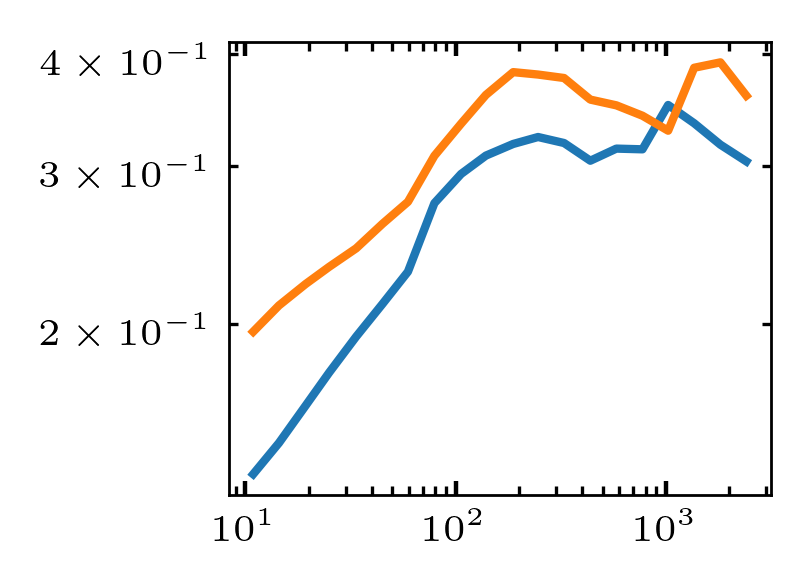

In [68]:
# test postprocess_gnf
data = pd.read_csv(r'E:\moreData\08032020\df2_kinetics\01\kinetics_data.csv')
gnf_data = data.loc[data.segment==50]
lb = 10
x, y = postprocess_gnf(gnf_data, lb, xlim=[10, 10000], sparse=3, normalize='cali', volume_fraction=80*0.0012, mean_intensity=153.6)
plt.plot(x, y, label='1')
data = pd.read_csv(r'E:\moreData\08032020\df2_kinetics\07\kinetics_data.csv')
gnf_data = data.loc[data.segment==70]
lb = 10
x, y = postprocess_gnf(gnf_data, lb, xlim=[10, 10000], sparse=3, normalize='cali', volume_fraction=40*0.0012, mean_intensity=153.8)
plt.plot(x, y, label='1')

plt.loglog()

## 4 Prepare data

In [92]:
conc, folders, sample_num = tentative_log()
lb = 10
seg_length = 50
out_folder = 'normalization_test'
out_filename = 'nGNF_data.csv'
master_file = r'E:\moreData\{0}\df2_kinetics\{1:02d}\kinetics_data.csv'
intensity_master_file = os.path.join(data_master_dir, r'Research projects\DF\data\level-2-data\{0}\overall_intensity\{1:02d}\intensity.csv')

for c, f, s in zip(conc, folders, sample_num):
    for sn in s:
        file = master_file.format(f, sn)
        intensity_file = intensity_master_file.format(f, sn)
        k_data = pd.read_csv(file)
        i_data = pd.read_csv(intensity_file).set_index('t')
        intensity = float(i_data[-100:].mean())
        volume_fraction = c * 12e-4
        for num, seg in enumerate(k_data.segment.drop_duplicates()):
            subdata = k_data.loc[k_data.segment==seg]
            x, y = postprocess_gnf(subdata, lb, xlim=[1, 10000], sparse=1, 
                                   normalize='cali', volume_fraction=volume_fraction, mean_intensity=intensity)
            temp = pd.DataFrame(data={'l_r': x, str((seg-1)*seg_length): y}).set_index('l_r')
            if num == 0:
                master = temp
            else:
                master = pd.concat([master, temp], axis=1)
        dest_file = r'E:\Google Drive\Research projects\DF\data\normalization_test\{0}\df2_kinetics\{1:02d}\nGNF_data.csv'.format(f, sn)
        dest_folder = os.path.split(dest_file)[0]
        if os.path.exists(dest_folder) == False:
            os.makedirs(dest_folder)
        master.to_csv(dest_file)
        print("Write {0}-{1:02d}".format(f, sn))
        clear_output(wait=True)

Write 08042020-11


## 5 Plot

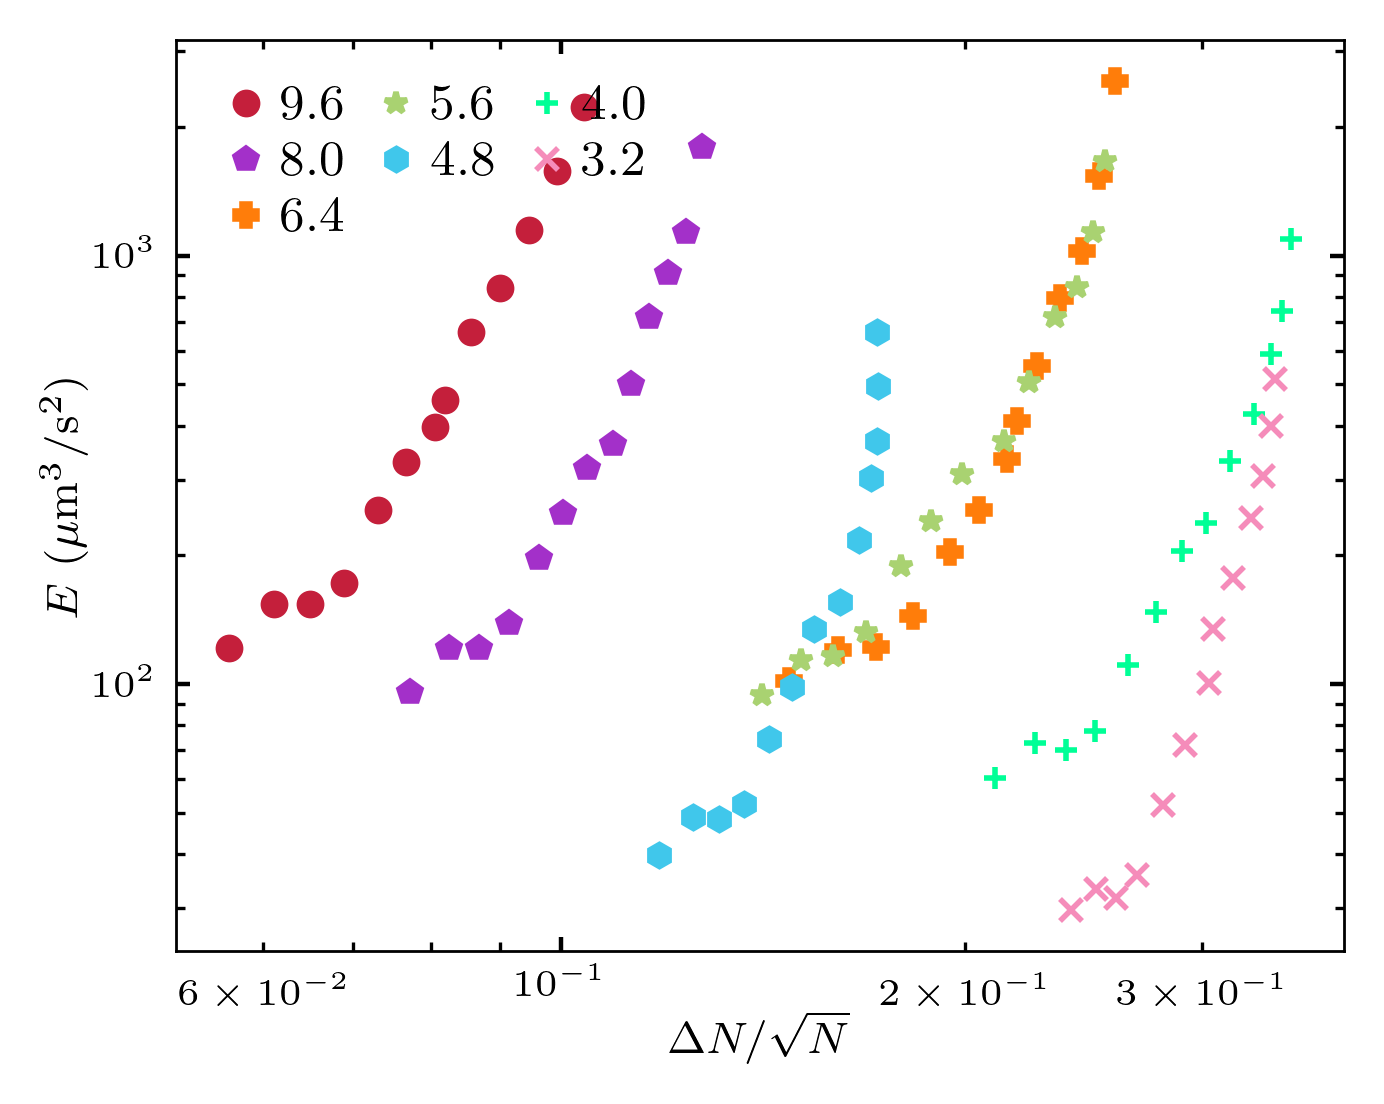

In [109]:
conc, folders, sample_num = tentative_log()
gnf_master_file = os.path.join(data_master_dir, 
                               r'Research projects\DF\data\normalization_test\{0}\df2_kinetics\{1:02d}\nGNF_data.csv')
es_master_file = os.path.join(data_master_dir, 
                               r'Research projects\DF\data\transient-nGNF-energy\{0}\energy_spectra\{1:02d}\energy_spectra.csv')
bounds = [16, 200]

fig, ax = plt.subplots(figsize=(3.5, 2.8))
for c, f, sn in zip(conc, folders, sample_num):
    n = sn[2]
    gnf_data = pd.read_csv(gnf_master_file.format(f, n)).set_index('l_r')[bounds[0]: bounds[1]]
    es_data = pd.read_csv(es_master_file.format(f, n)).set_index('l_r')[bounds[0]: bounds[1]]
    gnf = gnf_data.drop(labels=gnf_data.keys()[:-15], axis=1).mean(axis=1)
    es = es_data.drop(labels=es_data.keys()[:-15], axis=1).mean(axis=1)
    x, gnf_plot = xy_bin(gnf.index, gnf, bins=es.index)
    x, es_plot = xy_bin(es.index, es, bins=es.index)
    if c > 30 and c != 85:
        ax.plot(gnf_plot, es_plot, 
                ls='', marker=marker_list[color_dict[str(c)]], markersize=4, 
                color=wowcolor(color_dict[str(c)]), label='{:.1f}'.format(c*0.08))
#     elif c <= 30:
#         ax.plot(gnf_plot, es_plot, 
#                 ls='', marker=marker_list[color_dict[str(c)]], markersize=4, 
#                 color=(0.8, 0.8, 0.8), label='{:.1f}'.format(c*0.08))
ax.loglog()
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.set_xlabel('$\Delta N/\sqrt N$')
ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.tight_layout()